In [10]:
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def augustus_refs(df):
    out_df= pd.DataFrame()
    accessions=df["accession"].unique().tolist()
    for acc in accessions:    
        busco = pd.read_csv(f"/ebio/abt6_projects7/dliso/dlis/leon_pipeline/analysis/sqanti/ref_genes/augustus_mappings/busco_{acc}.txt", header=None)
        house = pd.read_csv(f"/ebio/abt6_projects7/dliso/dlis/leon_pipeline/analysis/sqanti/ref_genes/augustus_mappings/housekeeping_{acc}.txt", header=None)
        nlr = pd.read_csv(f"/ebio/abt6_projects7/dliso/dlis/leon_pipeline/analysis/sqanti/ref_genes/augustus_mappings/nlrs_{acc}.txt", header=None)

        busco["type"] = "busco"
        house["type"] = "housekeeping"
        nlr["type"] = "nlr"
        gene_type = pd.concat([busco,house,nlr])
        gene_type.columns = ["ref_isoform","type"]
        gene_type = gene_type.groupby("ref_isoform")["type"].apply(', '.join).reset_index()

        gene_type["ref_gene"] = gene_type["ref_isoform"].str.split(".").str[0]
        gene_type.loc[gene_type["type"] == "busco, nlr"] = "nlr"
        gene_type.loc[gene_type["type"] == "housekeeping, nlr"] = "nlr"
        gene_type.loc[gene_type["type"] == "busco, housekeeping"] = "housekeeping"

        sub=df.loc[df["accession"]==acc]
        sub = pd.merge(left=sub, right=gene_type, how='left', left_on='associated_gene', right_on='ref_gene')
        
        out_df=pd.concat([out_df,sub])
    return out_df

In [12]:
def liftoff_refs(df):
    # get_df
    accessions=df["accession"].unique().tolist()

    busco = pd.read_csv("/ebio/abt6_projects7/dliso/dlis/leon_pipeline/analysis/sqanti/ref_genes/busco_Araport11_20221221.txt", header=None)
    house = pd.read_csv("/ebio/abt6_projects7/dliso/dlis/leon_pipeline/analysis/sqanti/ref_genes/arat_housekeeping.txt", header=None)
    nlr = pd.read_csv("/ebio/abt6_projects7/dliso/dlis/leon_pipeline/analysis/sqanti/ref_genes/nlrs_in_orthogroups_20221221.txt", header=None)

    busco["type"] = "busco"
    house["type"] = "housekeeping"
    nlr["type"] = "nlr"
    gene_type = pd.concat([busco,house,nlr])
    gene_type.columns = ["ref_isoform","type"]
    gene_type = gene_type.groupby("ref_isoform")["type"].apply(', '.join).reset_index()

    gene_type["ref_gene"] = gene_type["ref_isoform"].str.split(".").str[0]
    gene_type.loc[gene_type["type"] == "busco, nlr"] = "nlr"
    gene_type.loc[gene_type["type"] == "housekeeping, nlr"] = "nlr"
    gene_type.loc[gene_type["type"] == "busco, housekeeping"] = "housekeeping"
        
    gene_ref = pd.merge(left=df, right=gene_type, how='left', left_on='associated_gene', right_on='ref_gene')
    
    return gene_ref

In [13]:
def subsample(df, len_nlr, refname):
        ### Random subsampling form the genome
        # Preparation
        n=len_nlr
        exons_all, length_all, subs_all, cats_all=[],[],[],[]
        exons_dict, length_dict, subs_dict, cats_dict={},{},{},{}
        exons_final, length_final, subs_final, cats_final={},{},{},{}
        np.random.seed(42)
        seeds = np.random.choice(range(999999), size=10000, replace=False)

        # get snapshot of one iteration
        for i in range(len(seeds)):
            sub_df = df.sample(n, random_state=seeds[i], axis=0)
            exons_all.append(sub_df["exons"])
            length_all.append(sub_df["length"])
            subs_all.append(sub_df["subcategory"])
            cats_all.append(sub_df["structural_category"])

        # count occurences of all snapshots
        for subset in exons_all:
            for gene in subset:
                if gene in exons_dict.keys():
                    exons_dict[gene] +=1
                else:
                    exons_dict[gene] = 1

        for subset in length_all:
            for gene in subset:
                if gene in length_dict.keys():
                    length_dict[gene] +=1
                else:
                    length_dict[gene] = 1

        for subset in subs_all:
            for gene in subset:
                if gene in subs_dict.keys():
                    subs_dict[gene] +=1
                else:
                    subs_dict[gene] = 1
                    
        for subset in cats_all:
            for gene in subset:
                if gene in cats_dict.keys():
                    cats_dict[gene] +=1
                else:
                    cats_dict[gene] = 1

        # average the accumulated snaphot counts by the number of snapshots and get the probability by dividing all by all genes
        for key in exons_dict.keys():
            exons_final[key] = exons_dict[key]/len(seeds)

        for key in length_dict.keys():
            length_final[key] = length_dict[key]/len(seeds)

        for key in subs_dict.keys():
            subs_final[key] = subs_dict[key]/len(seeds)
            
        for key in cats_dict.keys():
            cats_final[key] = cats_dict[key]/len(seeds)
            
        exons_iters = pd.DataFrame.from_dict(exons_final, orient='index',columns=[f"{refname}_iters_exons"])
        exons_iters[f"{refname}_iters_exons_proportion"] = exons_iters[f"{refname}_iters_exons"]/n
        
        length_iters = pd.DataFrame.from_dict(length_final, orient='index',columns=[f"{refname}_iters_length"])
        length_iters[f"{refname}_iters_length_proportion"] = length_iters[f"{refname}_iters_length"]/n
        
        subs_iters = pd.DataFrame.from_dict(subs_final, orient='index',columns=[f"{refname}_iters_subs"])
        subs_iters[f"{refname}_iters_subs_proportion"] = subs_iters[f"{refname}_iters_subs"]/n
        
        cats_iters = pd.DataFrame.from_dict(cats_final, orient='index',columns=[f"{refname}_iters_cats"])
        cats_iters[f"{refname}_iters_cats_proportion"] = cats_iters[f"{refname}_iters_cats"]/n
        
        return exons_iters, length_iters, subs_iters, cats_iters

In [14]:
names=["pasa_augustus","pasa_liftoff"]
runs=["all_runs/pasa_augustus_sqanti.pkl","all_runs/pasa_liftoff_sqanti.pkl"]

df_exons=pd.DataFrame()
df_length=pd.DataFrame()
df_subs=pd.DataFrame()
df_cats=pd.DataFrame()

for name, run in zip(names,runs):
    # load full df
    ref=pd.read_pickle(f"{run}")
    
    # add new column
    ref["cat_assign"]="None"
    # and fill new colum based on 4 categories
    ref.loc[(ref["structural_category"] != "antisense") & (ref["structural_category"] != "fusion") & (ref["structural_category"] != "intergenic"), "cat_assign"]="one2one"
    ref.loc[(ref["structural_category"] == "antisense"), "cat_assign"]="antisense"
    ref.loc[(ref["structural_category"] == "fusion"), "cat_assign"]="fusion"
    ref.loc[(ref["structural_category"] == "intergenic") | (ref["structural_category"] == "genic_intron"), "cat_assign"]="novel"
    
    # in some cases, transcripts were reported as one2one even though the reads are spanning two genes.
    # In these cases, we have "fusion reads", but splicing results in perfect cds for one gene.
    # filter them and add replace the assignment
    ref["association"] = ref["associated_gene"].str.split("_").str.len()
    ref.loc[(ref["cat_assign"]=="one2one")&(ref["association"]>1), "cat_assign"] = "fusion"
    
    ref = ref.loc[ref["cat_assign"]=="one2one"]
    
    if run == "all_runs/pasa_liftoff_sqanti.pkl":
        ref =liftoff_refs(ref)
    else:
        ref =augustus_refs(ref)
        
    ref["type"].fillna('other', inplace=True)
    
    
    #---------------------
    
    run_exons=pd.DataFrame()
    run_length=pd.DataFrame()
    run_subs=pd.DataFrame()
    run_cats=pd.DataFrame()

    for acc in tqdm(ref["accession"].unique().tolist()):
        at = ref.loc[ref["accession"] == acc].copy()
        nlr = at.loc[at["type"] == "nlr"].copy()
        busco = at.loc[at["type"] == "busco"].copy()
        house = at.loc[at["type"] == "housekeeping"].copy()
        n=min(len(nlr), len(busco), len(house), len(at))
        refsets=[nlr, busco, house, at]
        refnames=["nlr", "busco", "house","all"]
        
        refset_exons_iters=pd.DataFrame()
        refset_length_iters=pd.DataFrame()
        refset_subs_iters=pd.DataFrame()
        refset_cats_iters=pd.DataFrame()
        for refset, refname in zip(refsets, refnames):
            exons_iters, length_iters, subs_iters, cats_iters = subsample(refset, n, refname)
            refset_exons_iters=pd.concat([refset_exons_iters,exons_iters], axis="columns")
            refset_length_iters=pd.concat([refset_length_iters,length_iters], axis="columns")
            refset_subs_iters=pd.concat([refset_subs_iters,subs_iters], axis="columns")
            refset_cats_iters=pd.concat([refset_cats_iters,cats_iters], axis="columns")

            
        ### combine all
        # Take care of exons
        a=pd.DataFrame(nlr["exons"].value_counts())
        a.columns=["nlr_exons"]
        a["nlr_exons_proportion"]=a["nlr_exons"]/len(nlr)

        b=pd.DataFrame(busco["exons"].value_counts())
        b.columns=["busco_exons"]
        b["busco_exons_proportion"]=b["busco_exons"]/len(busco)

        c=pd.DataFrame(house["exons"].value_counts())
        c.columns=["housekeeping_exons"]
        c["housekeeping_exons_proportion"]=c["housekeeping_exons"]/len(house)

        e=pd.DataFrame(at["exons"].value_counts())
        e.columns=["all_exons"]
        e["all_exons_proportion"]=e["all_exons"]/len(at)
        
        acc_exons=pd.concat([a,refset_exons_iters,b,c,e], axis="columns").fillna(0).sort_index().reset_index()
        acc_exons["accession"] = acc
        run_exons=pd.concat([run_exons, acc_exons])

        ### combine all
        # Take care of length
        a=pd.DataFrame(nlr["length"].value_counts())
        a.columns=["nlr_length"]
        a["nlr_length_proportion"]=a["nlr_length"]/len(nlr)

        b=pd.DataFrame(busco["length"].value_counts())
        b.columns=["busco_length"]
        b["busco_length_proportion"]=b["busco_length"]/len(busco)

        c=pd.DataFrame(house["length"].value_counts())
        c.columns=["housekeeping_length"]
        c["housekeeping_length_proportion"]=c["housekeeping_length"]/len(house)

        e=pd.DataFrame(at["length"].value_counts())
        e.columns=["all_length"]
        e["all_length_proportion"]=e["all_length"]/len(at)

        acc_length=pd.concat([a,refset_length_iters,b,c,e], axis="columns").fillna(0).sort_index().reset_index()
        acc_length["accession"] = acc
        run_length=pd.concat([run_length, acc_length])

        ### combine all
        # Take care of subs
        a=pd.DataFrame(nlr["subcategory"].value_counts())
        a.columns=["nlr_subs"]
        a["nlr_subs_proportion"]=a["nlr_subs"]/len(nlr)

        b=pd.DataFrame(busco["subcategory"].value_counts())
        b.columns=["busco_subs"]
        b["busco_subs_proportion"]=b["busco_subs"]/len(busco)

        c=pd.DataFrame(house["subcategory"].value_counts())
        c.columns=["housekeeping_subs"]
        c["housekeeping_subs_proportion"]=c["housekeeping_subs"]/len(house)

        e=pd.DataFrame(at["subcategory"].value_counts())
        e.columns=["all_subs"]
        e["all_subs_proportion"]=e["all_subs"]/len(at)

        acc_subs=pd.concat([a,refset_subs_iters,b,c,e], axis="columns").fillna(0).sort_index().reset_index()
        acc_subs["accession"] = acc
        run_subs=pd.concat([run_subs, acc_subs])
    
        ### combine all
        # Take care of cats
        a=pd.DataFrame(nlr["structural_category"].value_counts())
        a.columns=["nlr_cats"]
        a["nlr_cats_proportion"]=a["nlr_cats"]/len(nlr)

        b=pd.DataFrame(busco["structural_category"].value_counts())
        b.columns=["busco_cats"]
        b["busco_cats_proportion"]=b["busco_cats"]/len(busco)

        c=pd.DataFrame(house["structural_category"].value_counts())
        c.columns=["housekeeping_cats"]
        c["housekeeping_cats_proportion"]=c["housekeeping_cats"]/len(house)

        e=pd.DataFrame(at["structural_category"].value_counts())
        e.columns=["all_cats"]
        e["all_cats_proportion"]=e["all_cats"]/len(at)

        acc_cats=pd.concat([a,refset_cats_iters,b,c,e], axis="columns").fillna(0).sort_index().reset_index()
        acc_cats["accession"] = acc
        run_cats=pd.concat([run_cats, acc_cats])
    
    
    run_exons["run"] = name
    df_exons=pd.concat([df_exons, run_exons])
    
    run_length["run"] = name
    df_length=pd.concat([df_length, run_length])
    
    run_subs["run"] = name
    df_subs=pd.concat([df_subs, run_subs])
    
    run_cats["run"] = name
    df_cats=pd.concat([df_cats, run_cats])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [14:55<00:00, 49.74s/it]


In [15]:
df_exons["collapsing_tool"] = df_exons["run"].str.split("_").str[0]
df_exons["prediction_tool"] = df_exons["run"].str.split("_").str[1]
df_length["collapsing_tool"] = df_length["run"].str.split("_").str[0]
df_length["prediction_tool"] = df_length["run"].str.split("_").str[1]
df_subs["collapsing_tool"] = df_subs["run"].str.split("_").str[0]
df_subs["prediction_tool"] = df_subs["run"].str.split("_").str[1]
df_cats["collapsing_tool"] = df_cats["run"].str.split("_").str[0]
df_cats["prediction_tool"] = df_cats["run"].str.split("_").str[1]

In [17]:
df_exons.to_pickle("clear_cases_all/exons_ava.pkl")
df_length.to_pickle("clear_cases_all/length_ava.pkl")
df_subs.to_pickle("clear_cases_all/subs_ava.pkl")
df_cats.to_pickle("clear_cases_all/cats_ava.pkl")

In [131]:
df_subs=pd.read_pickle("clear_cases_all/subs_ava.pkl")

### Plot Violin of Categories vs Prediction Tool

In [132]:
order=['reference_match','alternative_3end','alternative_5end','alternative_3end5end',
       '3prime_fragment','5prime_fragment','internal_fragment','multi-exon',
       'intron_retention',
       'combination_of_known_junctions','combination_of_known_splicesites','mono-exon_by_intron_retention','at_least_one_novel_splicesite',
       'mono-exon']

In [133]:
sqanti_subs=df_subs[["index","accession","run","collapsing_tool","prediction_tool","nlr_subs_proportion","busco_subs_proportion","housekeeping_subs_proportion","all_iters_subs_proportion"]]

In [134]:
plot1=sqanti_subs.melt(id_vars=["index","accession","run", "collapsing_tool","prediction_tool"], value_vars=["nlr_subs_proportion","busco_subs_proportion","housekeeping_subs_proportion","all_iters_subs_proportion"])

In [135]:
plot1.head()

,index,accession,run,collapsing_tool,prediction_tool,variable,value
0,3prime_fragment,at6923,pasa_augustus,pasa,augustus,nlr_subs_proportion,0.005115
1,5prime_fragment,at6923,pasa_augustus,pasa,augustus,nlr_subs_proportion,0.015345
2,alternative_3end,at6923,pasa_augustus,pasa,augustus,nlr_subs_proportion,0.028133
3,alternative_3end5end,at6923,pasa_augustus,pasa,augustus,nlr_subs_proportion,0.109974
4,alternative_5end,at6923,pasa_augustus,pasa,augustus,nlr_subs_proportion,0.002558


Text(12.6, 0.57, 'n = 18')

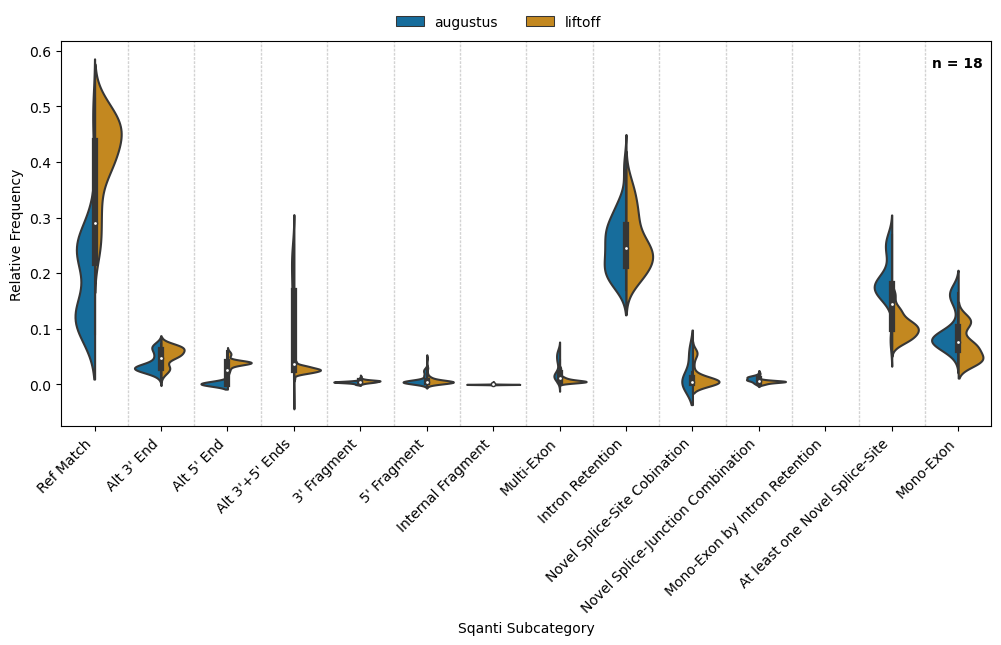

In [136]:
sns.set_palette(sns.color_palette("colorblind"))
plt.figure(figsize=(12,5))
p1_3_2=sns.violinplot(data=plot1, x="index", y="value", hue="prediction_tool", split=True, order=order)
p1_3_2.set_xticklabels(["Ref Match", "Alt 3' End", "Alt 5' End","Alt 3'+5' Ends","3' Fragment", "5' Fragment", "Internal Fragment", "Multi-Exon","Intron Retention","Novel Splice-Site Cobination","Novel Splice-Junction Combination","Mono-Exon by Intron Retention","At least one Novel Splice-Site","Mono-Exon"],rotation=45,horizontalalignment='right')
p1_3_2.set_xlabel("Sqanti Subcategory")
p1_3_2.set_ylabel("Relative Frequency")


sns.move_legend(p1_3_2, "lower center",
    bbox_to_anchor=(.47, 1), ncol=3, title=None, frameon=False,
)


for i in range(len(plot1["index"].unique().tolist())):
    plt.axvline( x=i+0.5, color="lightgrey", dashes=(2, 1), zorder=0,linewidth=1)
    
p1_3_2.text(12.6, 0.57, "n = 18", horizontalalignment='left', size='medium', color='black', weight='semibold')

In [137]:
fig = p1_3_2.get_figure()
fig.savefig("clear_cases_pasa_augustus-vs-liftoff_subcategories.png", bbox_inches='tight', dpi=200)

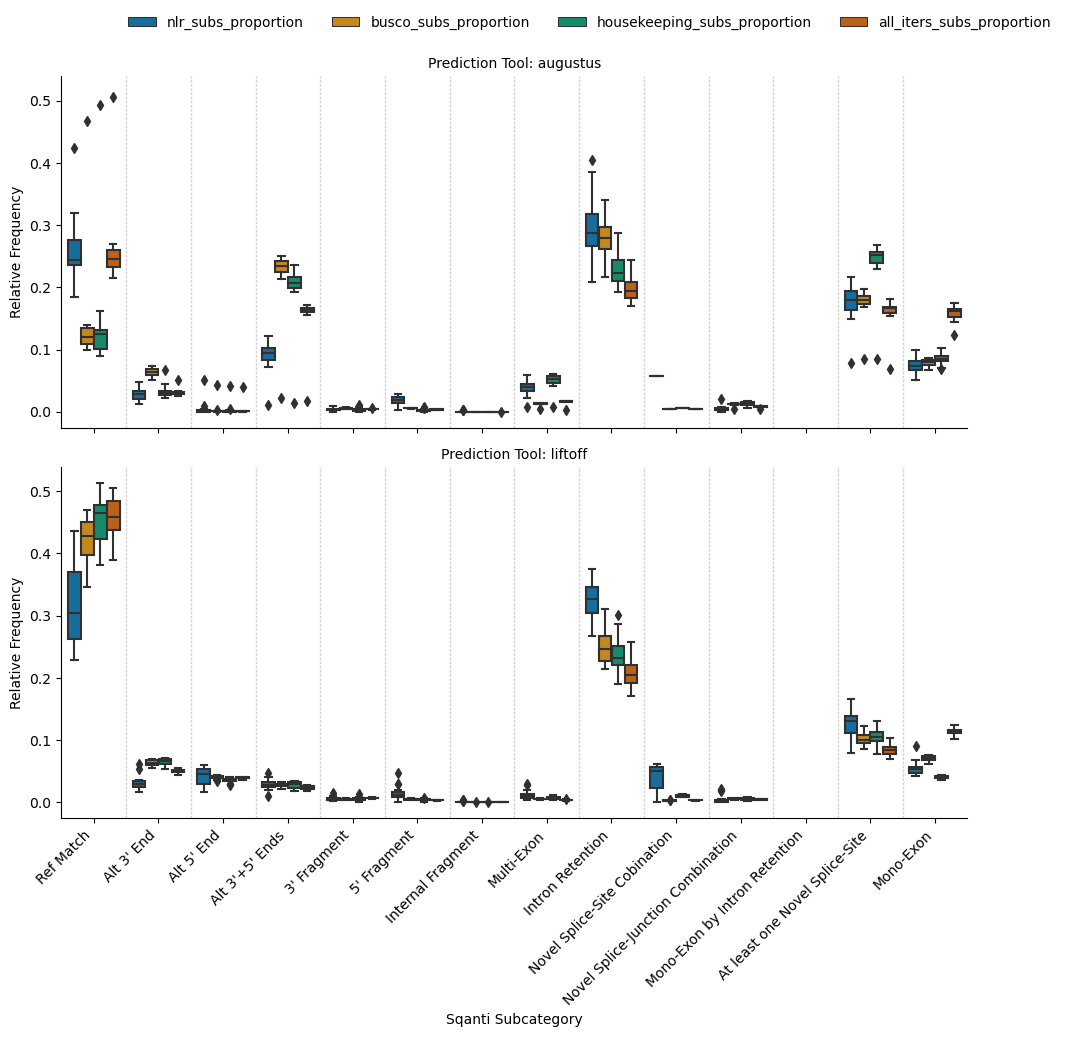

In [138]:
sns.set_palette(sns.color_palette("colorblind"))

p1=sns.catplot(data=plot1, x="index", y="value", hue="variable", col="prediction_tool", kind="box", col_wrap=1, aspect=2, order=order)
p1.set_xticklabels(rotation=45, horizontalalignment='right')


p1.set_xticklabels(["Ref Match", "Alt 3' End", "Alt 5' End","Alt 3'+5' Ends","3' Fragment", "5' Fragment", "Internal Fragment", "Multi-Exon","Intron Retention","Novel Splice-Site Cobination","Novel Splice-Junction Combination","Mono-Exon by Intron Retention","At least one Novel Splice-Site","Mono-Exon"],rotation=45,horizontalalignment='right')
p1.set_xlabels("Sqanti Subcategory")
p1.set_ylabels("Relative Frequency")
p1.set_titles(col_template="Prediction Tool: {col_name}")
sns.move_legend(p1, "lower center",
    bbox_to_anchor=(.47, 1), ncol=4, title=None, frameon=False,
)



for i in range(len(plot1["index"].unique().tolist())):
    p1.map(plt.axvline, x=i+0.5, color="lightgrey", dashes=(2, 1), zorder=0,linewidth=1)

In [139]:
fig = p1.fig
fig.savefig("clear_cases_pasa_augustus-liftoff_subcategories.png", bbox_inches='tight')

### Plot subcategories for the two updated prediction runs

#### Augustus

In [118]:
ta = df_subs[(df_subs["prediction_tool"]=="augustus")&(df_subs["collapsing_tool"]=="pasa")]

In [119]:
sqanti_subs=ta[["index","accession","run","nlr_subs_proportion","busco_subs_proportion","housekeeping_subs_proportion","all_iters_subs_proportion"]]

In [120]:
plot1=sqanti_subs.melt(id_vars=["index","accession","run"], value_vars=["nlr_subs_proportion","busco_subs_proportion","housekeeping_subs_proportion","all_iters_subs_proportion"])

In [121]:
plot1

,index,accession,run,variable,value
0,3prime_fragment,at6923,pasa_augustus,nlr_subs_proportion,0.005115
1,5prime_fragment,at6923,pasa_augustus,nlr_subs_proportion,0.015345
2,alternative_3end,at6923,pasa_augustus,nlr_subs_proportion,0.028133
3,alternative_3end5end,at6923,pasa_augustus,nlr_subs_proportion,0.109974
4,alternative_5end,at6923,pasa_augustus,nlr_subs_proportion,0.002558
...,...,...,...,...,...
843,internal_fragment,col0,pasa_augustus,all_iters_subs_proportion,0.000103
844,intron_retention,col0,pasa_augustus,all_iters_subs_proportion,0.170462
845,mono-exon,col0,pasa_augustus,all_iters_subs_proportion,0.123866
846,multi-exon,col0,pasa_augustus,all_iters_subs_proportion,0.003064


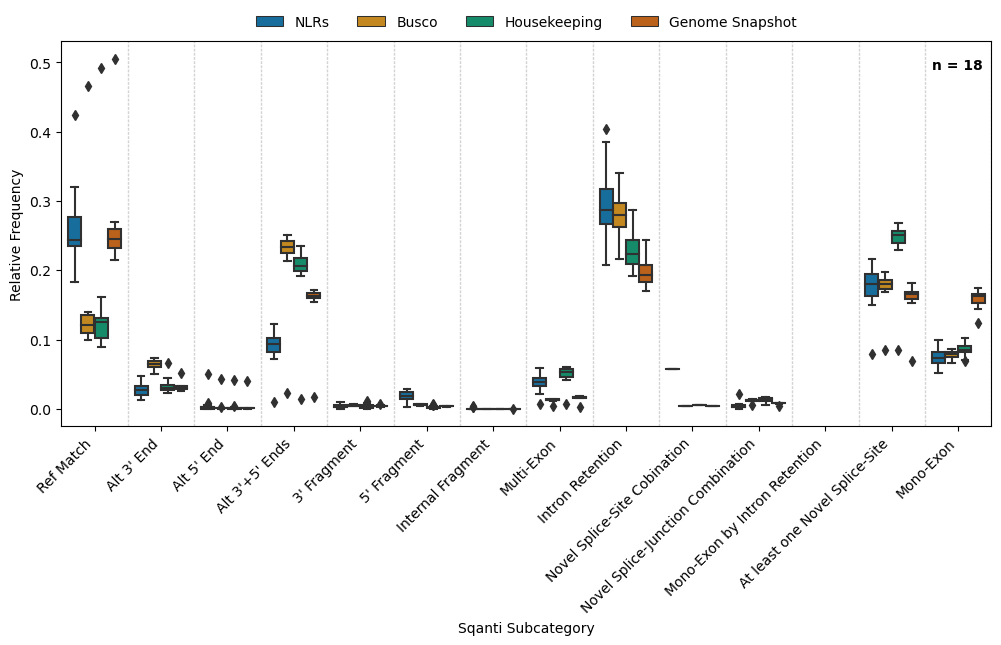

In [128]:
from matplotlib.pyplot import figure

plot1["variable_plot"] = plot1["variable"].map({'nlr_subs_proportion': 'NLRs', 'busco_subs_proportion': 'Busco', 'housekeeping_subs_proportion': 'Housekeeping', 'all_iters_subs_proportion':'Genome Snapshot'})
figure(figsize=(12, 5))

with sns.color_palette("colorblind"):
    p1_1=sns.boxplot(data=plot1, x="index", y="value", hue="variable_plot", order=order)
p1_1.set_xlabel("Sqanti Subcategory")
p1_1.set_ylabel("Relative Frequency")
p1_1.set_xticklabels(["Ref Match", "Alt 3' End", "Alt 5' End","Alt 3'+5' Ends","3' Fragment", "5' Fragment", "Internal Fragment", "Multi-Exon","Intron Retention",
                      "Novel Splice-Site Cobination","Novel Splice-Junction Combination","Mono-Exon by Intron Retention","At least one Novel Splice-Site","Mono-Exon"],
                     rotation=45,
                     horizontalalignment='right')

# adding lines in general: https://community.dataquest.io/t/i-want-to-add-vertical-lines-in-a-sns-facetgrid-how-can-i-do-that/546424/2
#for i in range(len(plot1["index"].unique().tolist())):
#    p1_1.map(plt.axvline, x=i+0.5, color="lightgrey", dashes=(2, 1), zorder=0,linewidth=1)
[p1_1.axvline(x+.5,color='lightgrey', dashes=(2,1), linewidth=1) for x in p1_1.get_xticks()]


## https://stackoverflow.com/questions/60350781/edit-legend-title-and-labels-of-seaborn-scatterplot-and-countplot

#p1_1.legend(legend_handles, ['NLRs', 'Busco','Housekeeling','Full Genome'], title='Gene Sets', bbox_to_anchor=(1.05, 1))

p1_1.text(12.6, 0.49, "n = 18", horizontalalignment='left', size='medium', color='black', weight='semibold')

#p1_1.legend(title='Gene Sets', bbox_to_anchor=(1.05, 1))
sns.move_legend(
    p1_1, "lower center",
    bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False,
)

In [130]:
fig = p1_1.get_figure()
fig.savefig("clear_cases_pasa_augustus_subcategories.png", bbox_inches='tight', dpi=200)

#### Liftoff

In [96]:
ta = df_subs[(df_subs["prediction_tool"]=="liftoff")&(df_subs["collapsing_tool"]=="pasa")]

In [97]:
sqanti_subs=ta[["index","accession","run","nlr_subs_proportion","busco_subs_proportion","housekeeping_subs_proportion","all_iters_subs_proportion"]]

In [98]:
plot1=sqanti_subs.melt(id_vars=["index","accession","run"], value_vars=["nlr_subs_proportion","busco_subs_proportion","housekeeping_subs_proportion","all_iters_subs_proportion"])

In [99]:
plot1

,index,accession,run,variable,value
0,3prime_fragment,at6923,pasa_liftoff,nlr_subs_proportion,0.006211
1,5prime_fragment,at6923,pasa_liftoff,nlr_subs_proportion,0.009317
2,alternative_3end,at6923,pasa_liftoff,nlr_subs_proportion,0.020186
3,alternative_3end5end,at6923,pasa_liftoff,nlr_subs_proportion,0.020186
4,alternative_5end,at6923,pasa_liftoff,nlr_subs_proportion,0.054348
...,...,...,...,...,...
927,internal_fragment,col0,pasa_liftoff,all_iters_subs_proportion,0.000113
928,intron_retention,col0,pasa_liftoff,all_iters_subs_proportion,0.170478
929,mono-exon,col0,pasa_liftoff,all_iters_subs_proportion,0.124049
930,multi-exon,col0,pasa_liftoff,all_iters_subs_proportion,0.003036


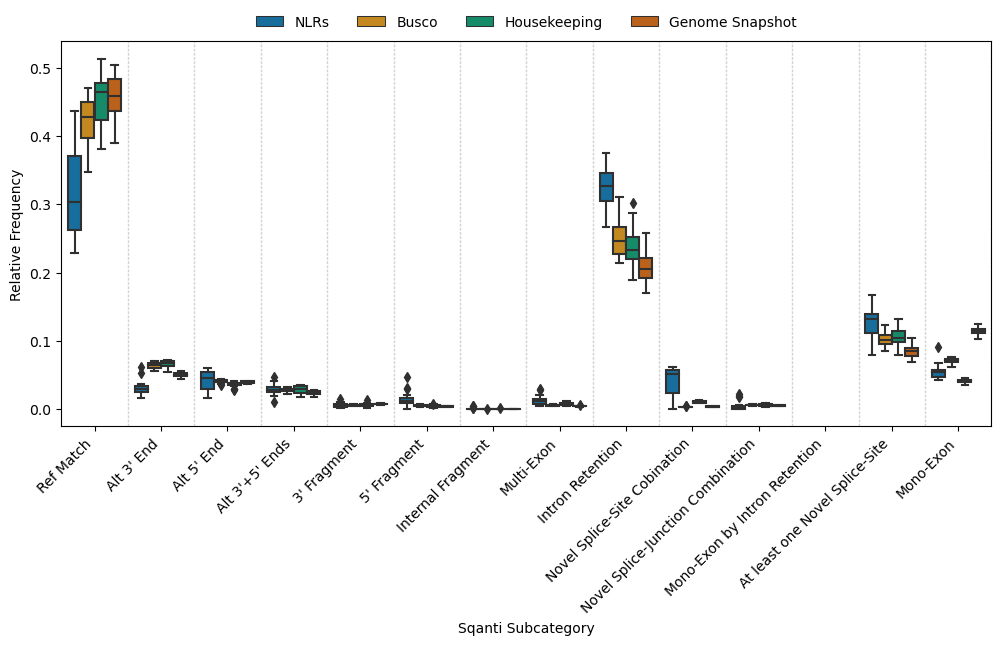

In [100]:
from matplotlib.pyplot import figure

plot1["variable_plot"] = plot1["variable"].map({'nlr_subs_proportion': 'NLRs', 'busco_subs_proportion': 'Busco', 'housekeeping_subs_proportion': 'Housekeeping', 'all_iters_subs_proportion':'Genome Snapshot'})
figure(figsize=(12, 5))

with sns.color_palette("colorblind"):
    p1_1=sns.boxplot(data=plot1, x="index", y="value", hue="variable_plot", order=order)
p1_1.set_xlabel("Sqanti Subcategory")
p1_1.set_ylabel("Relative Frequency")
p1_1.set_xticklabels(["Ref Match", "Alt 3' End", "Alt 5' End","Alt 3'+5' Ends","3' Fragment", "5' Fragment", "Internal Fragment", "Multi-Exon","Intron Retention",
                      "Novel Splice-Site Cobination","Novel Splice-Junction Combination","Mono-Exon by Intron Retention","At least one Novel Splice-Site","Mono-Exon"],
                     rotation=45,
                     horizontalalignment='right')

# adding lines in general: https://community.dataquest.io/t/i-want-to-add-vertical-lines-in-a-sns-facetgrid-how-can-i-do-that/546424/2
#for i in range(len(plot1["index"].unique().tolist())):
#    p1_1.map(plt.axvline, x=i+0.5, color="lightgrey", dashes=(2, 1), zorder=0,linewidth=1)
[p1_1.axvline(x+.5,color='lightgrey', dashes=(2,1), linewidth=1) for x in p1_1.get_xticks()]


## https://stackoverflow.com/questions/60350781/edit-legend-title-and-labels-of-seaborn-scatterplot-and-countplot

#p1_1.legend(legend_handles, ['NLRs', 'Busco','Housekeeling','Full Genome'], title='Gene Sets', bbox_to_anchor=(1.05, 1))


#p1_1.legend(title='Gene Sets', bbox_to_anchor=(1.05, 1))
sns.move_legend(
    p1_1, "lower center",
    bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False,
)

In [101]:
fig = p1_1.get_figure()
fig.savefig("clear_cases_pasa_liftoff_subcategories.png", bbox_inches='tight')